In [1]:
!pip install mlxtend
!pip install plotly
!pip install cufflinks
import pandas as pd
from datetime import datetime
import os
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.util import ngrams
import re
from textwrap import wrap
import collections
from nltk import FreqDist

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot
import cufflinks as cf

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Junrong\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Junrong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Junrong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Junrong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Junrong\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


C:\Users\Junrong\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [2]:
feedback_df = pd.read_csv('Feedback.csv',encoding = 'ISO-8859-1').sort_values(by=['Timestamp']).reset_index().drop(columns="index")
feedback_df.head()

,Timestamp,Name,Class Section,List one topic of the class that you enjoy,What was the most challenging topic of the class?,"Overall, the learning experience for the class is",(Optional) What do you suggest to improve the class?
0,10/1/2019 11:14,Student249,G4 (Tue 8:15 - 11:30 SR 3.4),Solution blueprinting,Solution overview model,3,There are too many diagrams. Takes a long time...
1,10/1/2019 11:14,Student60,G4 (Tue 8:15 - 11:30 SR 3.4),Solution Overview Model,Blueprint,3,NaN
2,10/1/2019 11:14,Student76,G4 (Tue 8:15 - 11:30 SR 3.4),Solution overview model,Teaching case 5 ( Looking for errors),3,NaN
3,10/1/2019 11:14,Student56,G4 (Tue 8:15 - 11:30 SR 3.4),Application,Solution overview model,3,-
4,10/1/2019 11:14,Student49,G4 (Tue 8:15 - 11:30 SR 3.4),application model,solution overview,2,NaN


In [3]:
def get_date(created):
    '''
    This function is to convert timestamp from UNIX
    '''
    return dt.datetime.fromtimestamp(created)

def lower_case(feedback):
    return feedback.lower()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

# remove all stop words and remove null
def remove_stopwords(feedback):
    stop_list = ['nil','gnil','nah','na','nan','haha','uhm','hehe']
    
    return [word for word in feedback if word not in stop_list]

def remove_symbols(feedback):
    whitelist = []
    return [re.sub(r'([^a-zA-Z0-9\s]+?)',' ',word) for word in feedback if word not in whitelist]

def remove_short_words(feedback):
    return [word for word in feedback if len(word) > 1]

def remove_apostrophes(feedback):
    return [re.sub(r"'s", "",word) for word in feedback]

def remove_digits(feedback):
    whitelist = []
    return [re.sub(r'\d+','',word) for word in feedback if word not in whitelist]

def remove_multispaces(feedback):
    #Replace multiple spaces with only 1 space
    return [re.sub(r' +', " ",word) for word in feedback]

def keep_alphanum(feedback):
    return [word for word in feedback if word.isalnum()]

def remove_consecutive(feedback):
    white_list = []
    return [re.sub(r'([a-z])\1\1+', r'\1\1',word) for word in feedback if word not in white_list]

def remove_duplicates_in_sentence(feedback):
    # remove duplicates
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', feedback)

def normalize_word(feedback):
    replacement_dict = {'mdm':'professor','perfecto':'perfect','perfection':'perfect','pls':'please', 'mins':'minute',
                        '15mins':'minute','abit':'a bit','thanks':'thank you','ty':'thank you','tks':'thank you',
                        'bc':'because','alittle':'a little','lil':'little','e.g.':'example','e.g':'example',
                        'i.e.':'example','i.e':'example','dunno':'do not know','perfectoo':'perfect','organisation':'organization',
                        'organisational':'organizational','alt+tab':'alt tab','pr0f':'professor','qn':'question','qns':'question','3/3':'',
                        'perfectooo':'perfect','nil.prof':'nil. prof', 'none':'','gdd':'good',':/':'',':d':'',':o':'',
                        '&':' and ','/':' or ','prof':'professor','thr':'there','proff':'professor','pleaseeeee':'please','hmmmmmmmmmm':''}
    feedback = [replacement_dict[word] if word in replacement_dict.keys() else word for word in feedback]
    feedback = remove_consecutive(feedback)

    return feedback

def lemmatize_words(feedback):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(feedback)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None and word not in stopwords.words('english'):
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        else:
            lemmatized_sentence.append(word)

    return (lemmatized_sentence)

# need to do the contractions dictionary
def expand_contractions(feedback):
    contractions = {"'cause": 'because',
                    "I'd": 'I would',
                    "I'd've": 'I would have',
                    "I'll": 'I will',
                    "I'll've": 'I will have',
                    "I'm": 'I am',
                    "I've": 'I have',
                    "ain't": 'am not',
                    "aren't": 'are not',
                    "can't": 'cannot',
                    "can't've": 'cannot have',
                    "could've": 'could have',
                    "couldn't": 'could not',
                    "couldn't've": 'could not have',
                    "didn't": 'did not',
                    "doesn't": 'does not',
                    "don't": 'do not',
                    "hadn't": 'had not',
                    "hadn't've": 'had not have',
                    "hasn't": 'has not',
                    "haven't": 'have not',
                    "he'd": 'he had',
                    "he'd've": 'he would have',
                    "he'll": 'he will',
                    "he'll've": 'he will have',
                    "he's": 'he is',
                    "how'd": 'how did',
                    "how'd'y": 'how do you',
                    "how'll": 'how will',
                    "how's": 'how is',
                    "i'd": 'i would',
                    "i'd've": 'i would have',
                    "i'll": 'i will',
                    "i'll've": 'i will have',
                    "i'm": 'i am',
                    "i've": 'i have',
                    "isn't": 'is not',
                    "it'd": 'it would',
                    "it'd've": 'it would have',
                    "it'll": 'it will',
                    "it'll've": 'it will have',
                    "it's": 'it is',
                    "let's": 'let us',
                    "ma'am": 'madam',
                    "mayn't": 'may not',
                    "might've": 'might have',
                    "mightn't": 'might not',
                    "mightn't've": 'might not have',
                    "must've": 'must have',
                    "mustn't": 'must not',
                    "mustn't've": 'must not have',
                    "needn't": 'need not',
                    "needn't've": 'need not have',
                    "o'clock": 'of the clock',
                    "oughtn't": 'ought not',
                    "oughtn't've": 'ought not have',
                    "sha'n't": 'shall not',
                    "shan't": 'shall not',
                    "shan't've": 'shall not have',
                    "she'd": 'she would',
                    "she'd've": 'she would have',
                    "she'll": 'she will',
                    "she'll've": 'she will have',
                    "she's": 'she is',
                    "should've": 'should have',
                    "shouldn't": 'should not',
                    "shouldn't've": 'should not have',
                    "so's": 'so as',
                    "so've": 'so have',
                    "that'd": 'that would',
                    "that'd've": 'that would have',
                    "that's": 'that is',
                    "there'd": 'there had',
                    "there'd've": 'there would have',
                    "there's": 'there is',
                    "they'd": 'they would',
                    "they'd've": 'they would have',
                    "they'll": 'they will',
                    "they'll've": 'they will have',
                    "they're": 'they are',
                    "they've": 'they have',
                    "to've": 'to have',
                    "wasn't": 'was not',
                    "we'd": 'we would',
                    "we'd've": 'we would have',
                    "we'll": 'we will',
                    "we'll've": 'we will have',
                    "we're": 'we are',
                    "we've": 'we have',
                    "weren't": 'were not',
                    "what'll": 'what will',
                    "what'll've": 'what will have',
                    "what're": 'what are',
                    "what's": 'what is',
                    "what've": 'what have',
                    "when's": 'when is',
                    "when've": 'when have',
                    "where'd": 'where did',
                    "where's": 'where is',
                    "where've": 'where have',
                    "who'll": 'who will',
                    "who'll've": 'who will have',
                    "who's": 'who is',
                    "who've": 'who have',
                    "why's": 'why is',
                    "why've": 'why have',
                    "will've": 'will have',
                    "won't": 'will not',
                    "won't've": 'will not have',
                    "would've": 'would have',
                    "wouldn't": 'would not',
                    "wouldn't've": 'would not have',
                    "y'all": 'you all',
                    "y'all'd": 'you all would',
                    "y'all'd've": 'you all would have',
                    "y'all're": 'you all are',
                    "y'all've": 'you all have',
                    "y'alls": 'you alls',
                    "you'd": 'you would',
                    "you'd've": 'you would have',
                    "you'll": 'you will',
                    "you'll've": 'you you will have',
                    "you're": 'you are',
                    "you've": 'you have'}
    return [contractions[word] if word in contractions.keys() else word for word in feedback]

def remove_duplicates_in_sentence(feedback):
    # remove duplicates
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', feedback)

def clean_text(feedbacks):
    new_feedbacks = [lower_case(str(feedback)) for feedback in feedbacks]
    new_feedbacks = [nltk.word_tokenize(str(feedback)) for feedback in new_feedbacks]
    new_feedbacks = [remove_digits(feedback) for feedback in new_feedbacks]
    new_feedbacks = [normalize_word(feedback) for feedback in new_feedbacks]
    
    new_feedbacks = [expand_contractions(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_apostrophes(feedback) for feedback in new_feedbacks]
    
    new_feedbacks = [remove_symbols(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_multispaces(feedback) for feedback in new_feedbacks]
    
    new_feedbacks = [' '.join(feedback) for feedback in new_feedbacks]
    new_feedbacks = [nltk.word_tokenize(str(feedback)) for feedback in new_feedbacks]
    
    new_feedbacks = [lemmatize_words(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_stopwords(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_short_words(feedback) for feedback in new_feedbacks]
    new_feedbacks = [' '.join(feedback) for feedback in new_feedbacks]
    new_feedbacks = [remove_duplicates_in_sentence(str(feedback)) for feedback in new_feedbacks]

    return new_feedbacks


def remove_text(df,col):
    # # replace values for the following
    remove_lines = ['too early to discover','nothing as of now','no','today very good','week reflection','name',
                    'nothing','no comment','nope','week'
                    ]
    df = df[~df[col].isin(remove_lines)]                 
    return df


def null_visualization(feedback_df):
    sns.heatmap(feedback_df.isnull(), cbar=False)

# Exploratory Data Analysis

#### Brief summary of counts and top values

In [4]:
feedback_df.describe(include = np.object).transpose()

,count,unique,top,freq
Timestamp,3099,2419,9/4/2019 15:13,22
Name,3099,376,Student103,11
Class Section,3099,9,G6 (Thur 8:15 - 11:30 SR 3.4),457
List one topic of the class that you enjoy,3092,2179,Collaboration Model,41
What was the most challenging topic of the class?,3081,2339,-,55
(Optional) What do you suggest to improve the class?,1277,771,NIL,151


#### Null values visualization

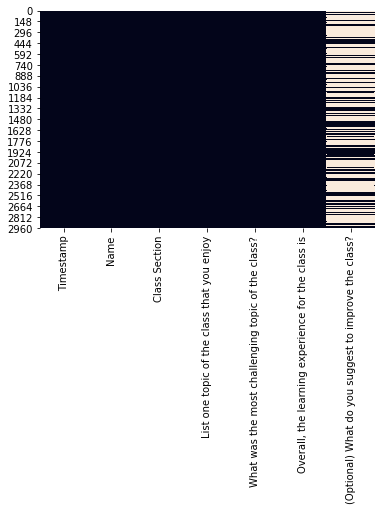

In [5]:
null_visualization(feedback_df)

#### Words with symbols

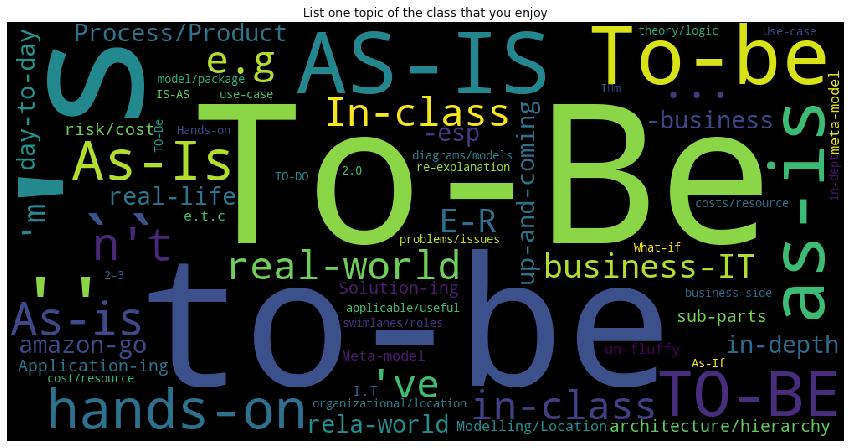

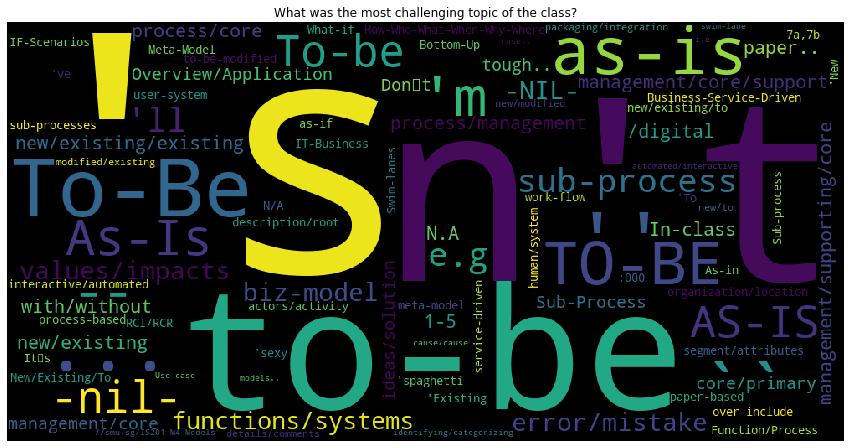

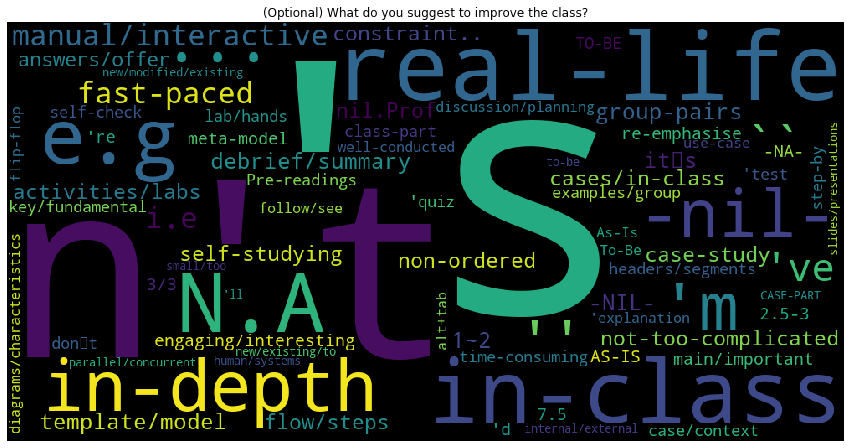

In [6]:
cols = ['List one topic of the class that you enjoy','What was the most challenging topic of the class?','(Optional) What do you suggest to improve the class?']
for col in cols:
    ans = []
    for feedback in feedback_df[col]:
        feedback = str(feedback)
        feedback = nltk.word_tokenize(feedback)
        for word in feedback:
            if re.findall('\W\S',word) != []:
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)
    
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(col)
    plt.show()

#### Looking at words containing digits

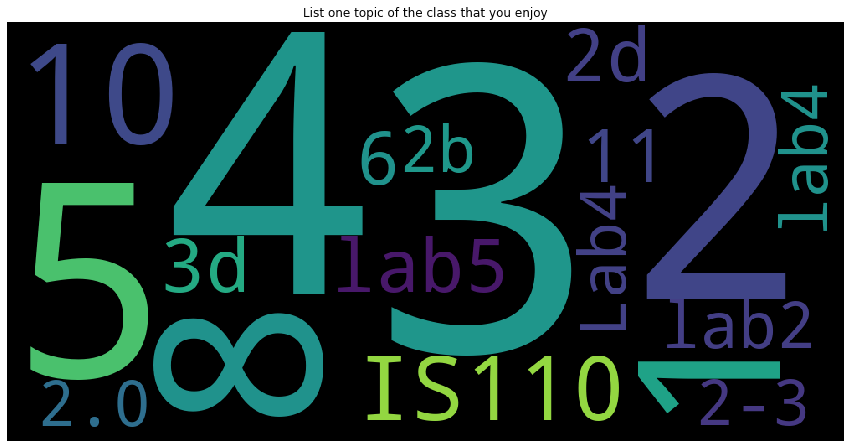

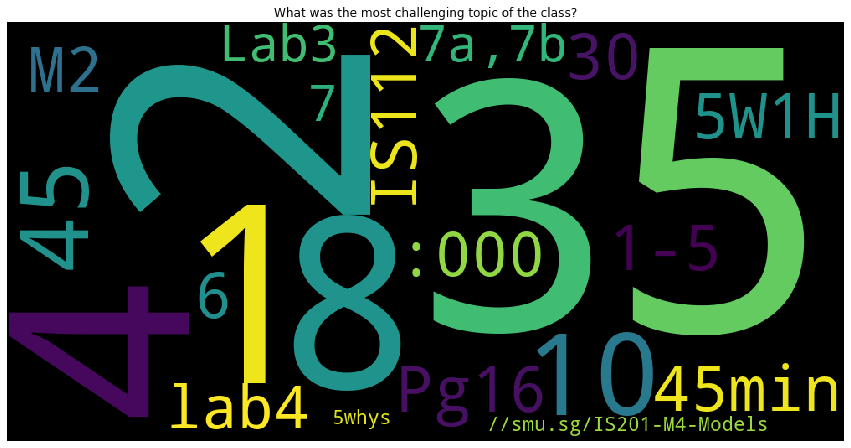

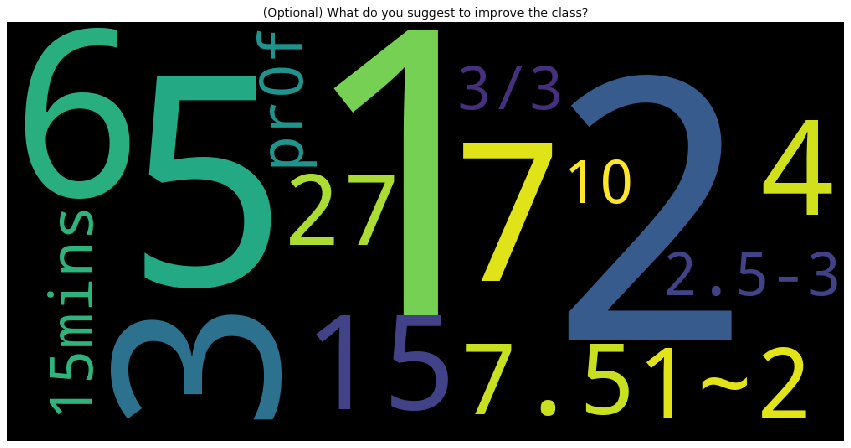

In [7]:
for col in cols:
    ans = []
    for feedback in feedback_df[col]:
        feedback = str(feedback)
        feedback = nltk.word_tokenize(feedback)
        for word in feedback:
            if re.findall(r'\d+',word) != []:
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(col)
    plt.show()

#### Looking at words with consecutive characters

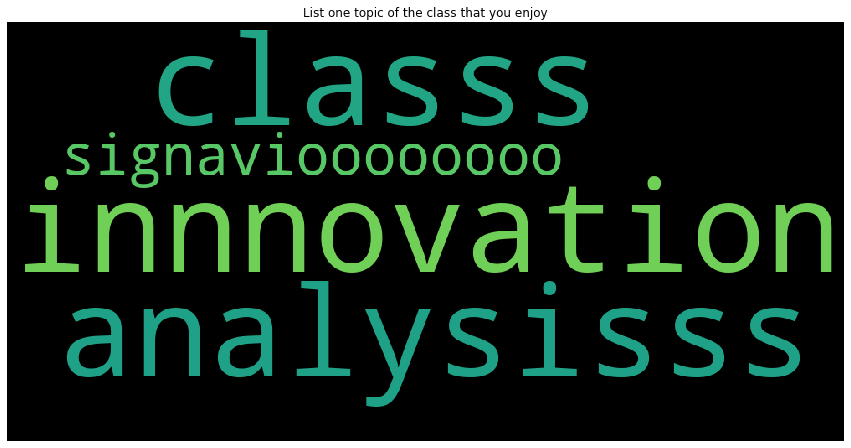

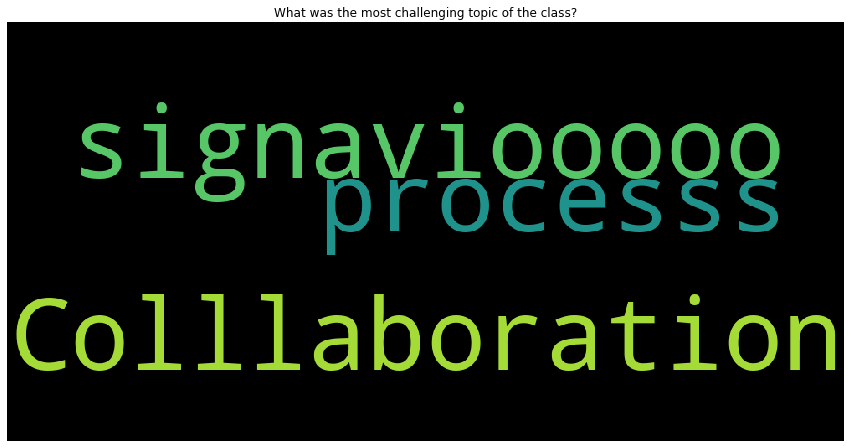

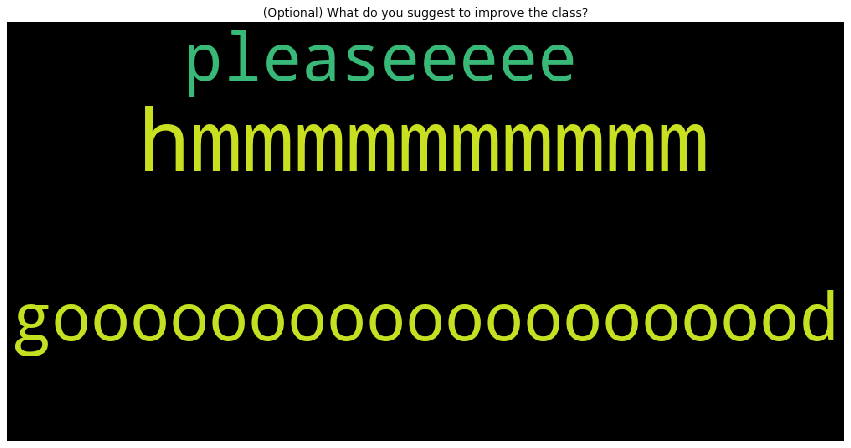

In [8]:
for col in cols:
    ans = []
    for feedback in feedback_df[col]:
        feedback = str(feedback)
        feedback = nltk.word_tokenize(feedback)
        for word in feedback:
            if re.findall(r'([a-z])\1\1+',word) != []:
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(col)
    plt.show()

#### Looking at words with length of 2 and are alphabets

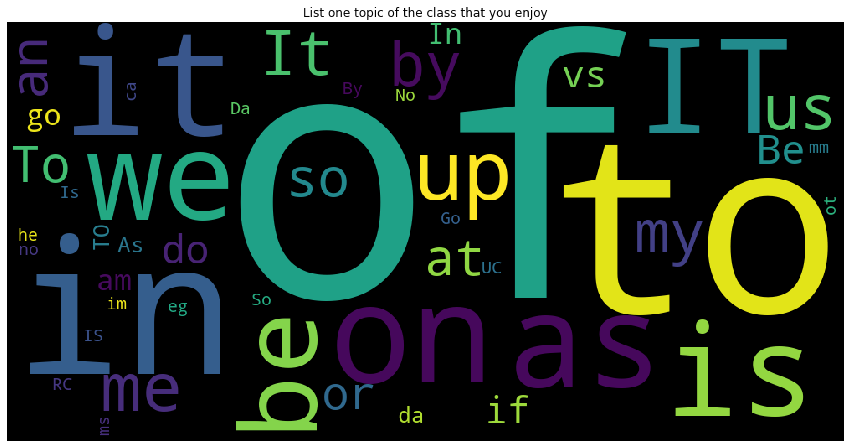

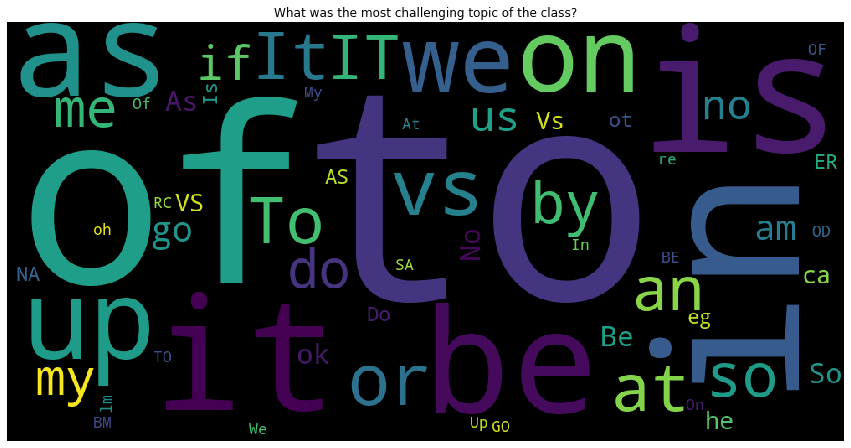

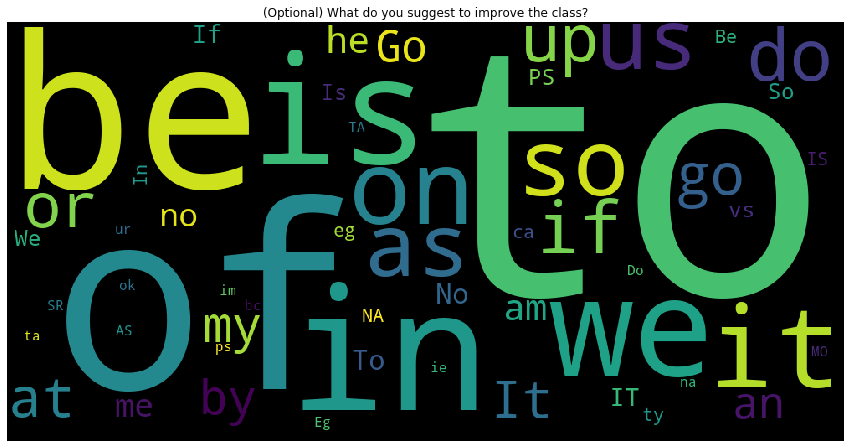

In [9]:
for col in cols:
    ans = []
    for feedback in feedback_df[col]:
        feedback = str(feedback)
        feedback = nltk.word_tokenize(feedback)
        for word in feedback:
            if len(word) == 2 and word.isalpha():
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(col)
    plt.show()

#### Looking at words with length of 1 and are alphabets

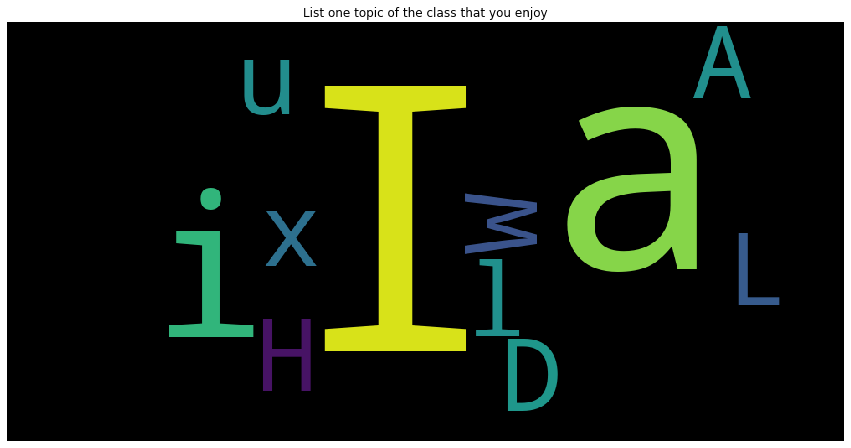

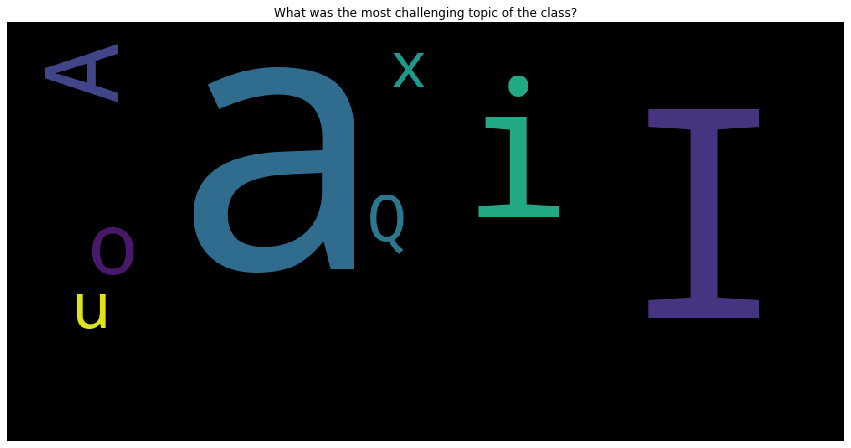

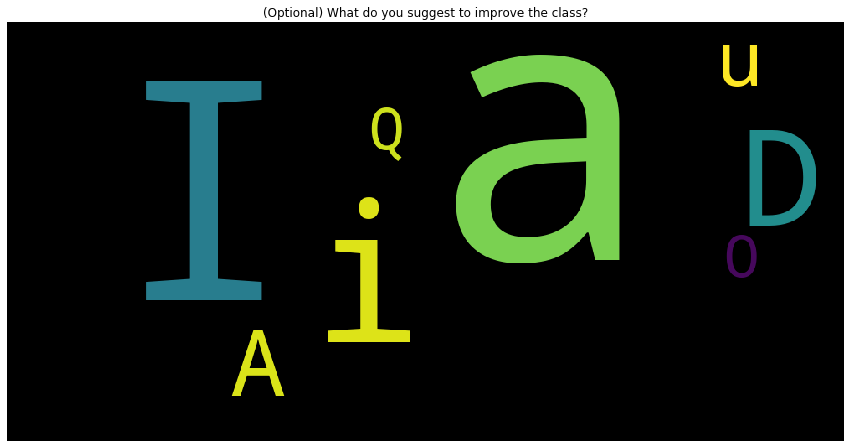

In [10]:
for col in cols:
    ans = []
    for feedback in feedback_df[col]:
        feedback = str(feedback)
        feedback = nltk.word_tokenize(feedback)
        for word in feedback:
            if len(word) == 1 and word.isalpha():
                ans.append(word)

    word_cloud_dict=Counter(ans)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(col)
    plt.show()

#### Check for duplicate feedbacks in dataset

In [11]:
duplicate_rows_df = feedback_df[feedback_df.duplicated()]
print('number of duplicate rows:', duplicate_rows_df.shape[0])

number of duplicate rows: 0


### Text Pre-processing

In [12]:
cleaned_feedback_df = feedback_df.copy()
for col in cols:
    cleaned_feedback_df['cleaned_'+ col] = clean_text(cleaned_feedback_df[col].tolist())
    cleaned_feedback_df = remove_text(cleaned_feedback_df,col)
    cleaned_feedback_df['cleaned_'+ col] = cleaned_feedback_df['cleaned_'+ col].replace({'nan':''},regex=True)
    
cleaned_feedback_df.to_csv('cleaned_feedback.csv',index=False)
cleaned_feedback_df.head()

,Timestamp,Name,Class Section,List one topic of the class that you enjoy,What was the most challenging topic of the class?,"Overall, the learning experience for the class is",(Optional) What do you suggest to improve the class?,cleaned_List one topic of the class that you enjoy,cleaned_What was the most challenging topic of the class?,cleaned_(Optional) What do you suggest to improve the class?
0,10/1/2019 11:14,Student249,G4 (Tue 8:15 - 11:30 SR 3.4),Solution blueprinting,Solution overview model,3,There are too many diagrams. Takes a long time...,solution blueprinting,solution overview model,there are too many diagram take long time to s...
1,10/1/2019 11:14,Student60,G4 (Tue 8:15 - 11:30 SR 3.4),Solution Overview Model,Blueprint,3,NaN,solution overview model,blueprint,
2,10/1/2019 11:14,Student76,G4 (Tue 8:15 - 11:30 SR 3.4),Solution overview model,Teaching case 5 ( Looking for errors),3,NaN,solution overview model,teach case look for error,
3,10/1/2019 11:14,Student56,G4 (Tue 8:15 - 11:30 SR 3.4),Application,Solution overview model,3,-,application,solution overview model,
4,10/1/2019 11:14,Student49,G4 (Tue 8:15 - 11:30 SR 3.4),application model,solution overview,2,NaN,application model,solution overview,


#### Visualizing the distribution of the feedback words/length

For column: List one topic of the class that you enjoy
Distribution of length of feedback


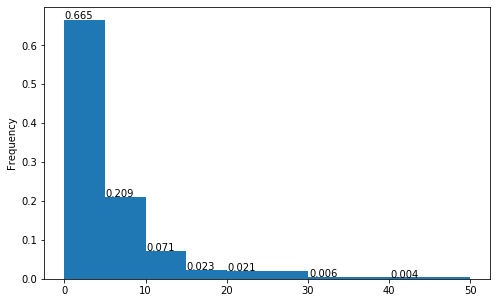

Minimum feedback length: 0
Maximum feedback length 536
Minimum number of words 0
Maximum number of words 97


For column: What was the most challenging topic of the class?
Distribution of length of feedback


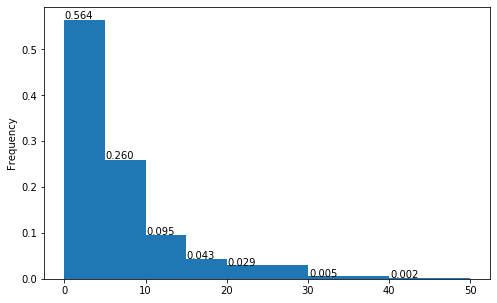

Minimum feedback length: 0
Maximum feedback length 367
Minimum number of words 0
Maximum number of words 69


For column: (Optional) What do you suggest to improve the class?
Distribution of length of feedback


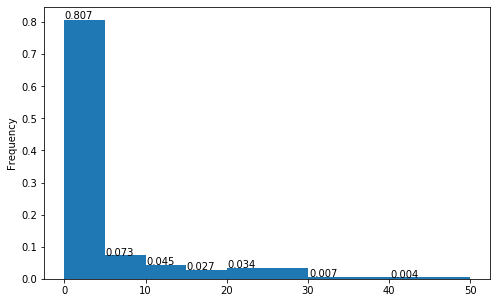

Minimum feedback length: 0
Maximum feedback length 831
Minimum number of words 0
Maximum number of words 152




In [13]:
for col in cols:
    print("For column:",col)
    
    print("Distribution of length of feedback")
    ax = cleaned_feedback_df['cleaned_'+col].str.split().map(len).plot.hist(bins=[0,5,10,15,20,30,40,50],figsize=(8,5),weights = np.ones_like(cleaned_feedback_df.index) / len(cleaned_feedback_df.index))
    for p in ax.patches:
        ax.annotate(str('{0:.3f}'.format((p.get_height()))), (p.get_x() * 1.005, p.get_height() * 1.005))
    plt.show()
    
    print("Minimum feedback length:",cleaned_feedback_df['cleaned_'+col].apply(len).min())
    print("Maximum feedback length",cleaned_feedback_df['cleaned_'+col].apply(len).max())
    print("Minimum number of words",cleaned_feedback_df['cleaned_'+col].str.split().map(len).min())
    print("Maximum number of words",cleaned_feedback_df['cleaned_'+col].str.split().map(len).max())
    print("\n")

#### Visualizing the common words of the feedbacks

We only visualize the most common words. These may or may not be removed depending on our tasks and further preprocessing methods by each of our tasks.

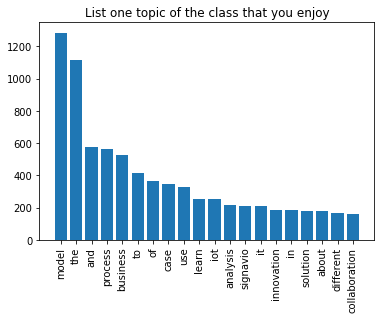

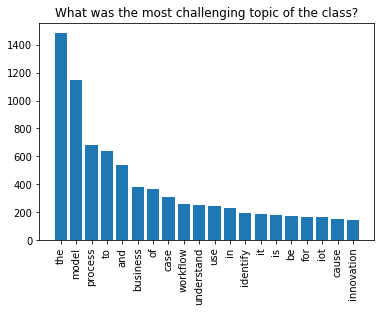

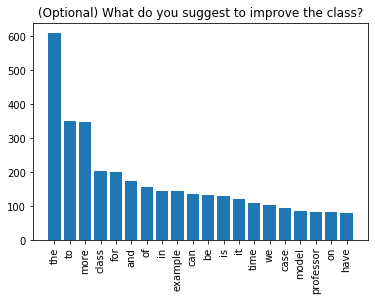

In [14]:
for col in cols:
    docs = cleaned_feedback_df['cleaned_'+col].str.split().tolist()
    docs = [word  for fb in docs for word in fb] 
    fdist = Counter(docs)
    plt.bar(pd.DataFrame(fdist.most_common(20)).loc[:,0],pd.DataFrame(fdist.most_common(20)).loc[:,1])
    plt.title(col)
    plt.xticks(rotation=90)
    plt.show()